## Generate user data with interaction label

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Load the full trainer dataset
pt_path = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
df = pd.read_csv(pt_path)

# Convert specified columns to numeric and fill missing values with zero
for col in ['athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience', 'videos_count']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Define columns for log transformation and direct scaling
log_cols   = ['total_likes', 'videos_count']
scale_cols = ['workout_recommendations', 'athlete_rating', 'years_experience']
scaler     = MinMaxScaler()

# Apply log1p transform then Min–Max scale to skewed features
for c in log_cols:
    df[f'norm_{c}'] = scaler.fit_transform(np.log1p(df[[c]]))

# Apply Min–Max scale directly to remaining features
for c in scale_cols:
    df[f'norm_{c}'] = scaler.fit_transform(df[[c]])

# Use PCA to collapse normalized features into a single score dimension
pca_cols = [f'norm_{c}' for c in (log_cols + scale_cols)]
pca      = PCA(n_components=1).fit(df[pca_cols])
weights  = np.abs(pca.components_[0])
weights /= weights.sum()
df['score'] = df[pca_cols].dot(weights)

# Keep original specialties as strings and lists
df['specialities']    = df['specialities'].astype(str)
df['speciality_list'] = df['specialities'].str.split(',').apply(lambda lst: [s.strip() for s in lst])

# Function to sample trainers with fair coverage of specialties
def sample_with_fair_direction(df_layer, k, used_dirs, seed):
    shuffled = df_layer.sample(frac=1, random_state=seed)
    picked = []
    for _, row in shuffled.iterrows():
        dirs = set(row['speciality_list'])
        if not (dirs & used_dirs):
            picked.append(row)
            used_dirs |= dirs
        if len(picked) == k:
            break
    if len(picked) < k:
        for _, row in shuffled.iterrows():
            if row['trainer_id'] in {t['trainer_id'] for t in picked}:
                continue
            picked.append(row)
            if len(picked) == k:
                break
    return pd.DataFrame(picked), used_dirs

# Function to generate cold-start recommendations for a user
def generate_cold_start_recommendations(all_df, user_id, total_n=18):
    sorted_df = all_df.sort_values('score', ascending=False).reset_index(drop=True)
    n = len(sorted_df)
    layer_size = n // 3
    layers = [
        sorted_df.iloc[:layer_size],
        sorted_df.iloc[layer_size:2*layer_size],
        sorted_df.iloc[2*layer_size:]
    ]
    per_layer = total_n // 3
    used_dirs, samples = set(), []
    for i, layer in enumerate(layers):
        seed = abs(hash(f"{user_id}_{i}")) % (2**32)
        samp, used_dirs = sample_with_fair_direction(layer, per_layer, used_dirs, seed)
        samples.append(samp)
    final_df = pd.concat(samples, ignore_index=True).drop_duplicates('trainer_id')
    return final_df

# Generate synthetic user profiles
age_groups = ['young', 'middle', 'senior']
genders    = ['Male', 'Female']
goal_map   = {
    ('young','Female'): ['Yoga','Pilates','WeightLoss','HIIT','Flexibility','StrengthTraining','Cardio','PrenatalFitness'],
    ('young','Male')  : ['CrossFit','Bodybuilding','Powerlifting','HIIT','Sports-Specific','Cardio','StrengthTraining'],
    ('middle','Female'): ['Pilates','Flexibility','WeightLoss','FunctionalTraining','Yoga','StrengthTraining'],
    ('middle','Male')  : ['StrengthTraining','FunctionalTraining','MuscleBuilding','Sports-Specific','Cardio','HIIT'],
    ('senior','Female'): ['ElderlyFitness','Flexibility','Rehabilitation','Cardio','Pilates','FunctionalTraining'],
    ('senior','Male')  : ['ElderlyFitness','Flexibility','Rehabilitation','FunctionalTraining','Cardio']
}

users = []
for uid in range(10001, 15001):
    age    = random.choice(age_groups)
    gender = random.choice(genders)
    goals  = random.sample(goal_map[(age, gender)], k=random.choices([1, 2], [0.6, 0.4])[0])
    users.append({'user_id': uid, 'age_group': age, 'gender': gender, 'user_goals': ', '.join(goals)})
df_users = pd.DataFrame(users)

# Helper to compute overlap metrics between user goals and trainer specialties
def compute_overlap(goals, specs):
    G = set(goals.split(', '))
    S = set(specs)
    I = G & S
    U = G | S
    return {
        'overlap_count': len(I),
        'jaccard_score': len(I) / len(U) if U else 0.0,
        'direction_match': int(bool(I))
    }

# Function to assign a discrete label based on watch and rating behavior
def construct_label(watched_count, rated, score_given):
    if rated == 1:
        return 5 if score_given > 3 else 4
    if watched_count >= 3:
        return 3
    if watched_count > 1:
        return 2
    if watched_count == 1:
        return 1
    return 0

# Simulation parameters
VIDEO_NUM = 5
TRAINERS_PER_USER = 18
alpha     = 0.05   # Increment added to watch probability after each viewed video
p_max     = 0.95   # Maximum watch probability

interactions = []

for _, user in df_users.iterrows():
    picked = generate_cold_start_recommendations(df, user['user_id'], TRAINERS_PER_USER)
    for _, t in picked.iterrows():
        # calculate overlap metrics
        ov = compute_overlap(user['user_goals'], t['speciality_list'])
        
        # simulate watch behavior with linear probability increase
        base_prob = min(0.2 + 0.2 * ov['overlap_count'], p_max)
        watches   = []
        watch_sum = 0
        for _ in range(VIDEO_NUM):
            p_i = min(base_prob + alpha * watch_sum, p_max)
            w   = int(random.random() < p_i)
            watches.append(w)
            watch_sum += w
        
        # simulate rating decision
        if watch_sum >= 2:
            rated_prob = min(0.1 + 0.15 * watch_sum + 0.4 * ov['jaccard_score'], p_max)
            rated      = int(random.random() < rated_prob)
        else:
            rated = 0
        
        # simulate rating value
        if rated == 1:
            raw_score = np.random.normal(
                loc=2.5 + 0.3 * watch_sum + 1.5 * ov['jaccard_score'],
                scale=1.2
            )
            score = int(np.clip(round(raw_score), 1, 5))
        else:
            score = 0
        
        # construct final label
        label = construct_label(watch_sum, rated, score)
        
        # record interaction
        row = {
            **user,
            'trainer_id': t['trainer_id'],
            **{f'watch_v{i+1}': w for i, w in enumerate(watches)},
            'watched_count': watch_sum,
            'rated': rated,
            'score_given': score,
            **ov,
            'athlete_rating': t['athlete_rating'],
            'total_likes': t['total_likes'],
            'videos_count': t['videos_count'],
            'workout_recommendations': t['workout_recommendations'],
            'years_experience': t['years_experience'],
            'label': label
        }
        interactions.append(row)

# Save the synthetic interaction dataset
pd.DataFrame(interactions).to_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv", index=False)


## User interaction label rules:
### label 0：watched_count == 0

### label 1：watched_count == 1 & rated == 0

### label 2：watched_count == 2 & rated == 0

### label 3：watched_count ≥ 3 & rated == 0

### label 4：rated == 1 & score_given ≤ 3

### label 5：rated == 1 & score_given > 3

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import ndcg_score

# load interaction data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")

# split users into train/validation/test (70/15/15)
np.random.seed(42)
user_ids = df['user_id'].unique()
np.random.shuffle(user_ids)
n = len(user_ids)
train_u = set(user_ids[:int(n*0.7)])
val_u   = set(user_ids[int(n*0.7):int(n*0.85)])
test_u  = set(user_ids[int(n*0.85):])

train_df = df[df['user_id'].isin(train_u)].reset_index(drop=True)
val_df   = df[df['user_id'].isin(val_u)].reset_index(drop=True)
test_df  = df[df['user_id'].isin(test_u)].reset_index(drop=True)

print("Test dataset label frequency:\n", test_df['label'].value_counts())
print("Whole dataset label frequency:\n", df['label'].value_counts())


Test dataset label frequency:
 label
1    4728
0    4096
2    1705
4    1233
5    1153
3     585
Name: count, dtype: int64
Whole dataset label frequency:
 label
1    31402
0    27306
2    11410
4     8055
5     7836
3     3991
Name: count, dtype: int64


In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb

# Load data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")

# User-wise train/val/test split
user_ids = df['user_id'].unique()
np.random.seed(42)  # for reproducibility
np.random.shuffle(user_ids)

num_users = len(user_ids)
train_end = int(num_users * 0.7)
val_end = int(num_users * 0.85)

train_users = user_ids[:train_end]
val_users = user_ids[train_end:val_end]
test_users = user_ids[val_end:]

train_df = df[df['user_id'].isin(train_users)].reset_index(drop=True)
val_df = df[df['user_id'].isin(val_users)].reset_index(drop=True)
test_df = df[df['user_id'].isin(test_users)].reset_index(drop=True)

# Feature and label definition
features = [
    'jaccard_score',
    'overlap_count',
    'direction_match',
    'athlete_rating',
    'total_likes',
    'workout_recommendations',
    'years_experience'
]
label_col = 'label'
group_col = 'user_id'

# Prepare group sizes (number of samples per user)
def prepare_group(df, user_col):
    return df.groupby(user_col).size().tolist()

train_group = prepare_group(train_df, group_col)
val_group = prepare_group(val_df, group_col)

# Create LightGBM datasets
train_data = lgb.Dataset(train_df[features], label=train_df[label_col], group=train_group)
val_data = lgb.Dataset(val_df[features], label=val_df[label_col], group=val_group, reference=train_data)

# Define parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [5, 10],
    'learning_rate': 0.01,
    'num_leaves': 6,
    'min_data_in_leaf': 20,
    'verbose': -1
}

# Train with early stopping on validation set
ranker = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    valid_names=['validation'],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)]
)

# Prepare test set group info
test_group = prepare_group(test_df, group_col)

# Predict on test set
test_preds = ranker.predict(test_df[features])

test_df = test_df.copy()
test_df['predicted_score'] = test_preds

# Save the trained model
#ranker.save_model("/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user.txt")


Training until validation scores don't improve for 50 rounds
[10]	validation's ndcg@5: 0.452699	validation's ndcg@10: 0.538655
[20]	validation's ndcg@5: 0.4513	validation's ndcg@10: 0.540129
[30]	validation's ndcg@5: 0.451752	validation's ndcg@10: 0.540991
[40]	validation's ndcg@5: 0.451016	validation's ndcg@10: 0.536973
[50]	validation's ndcg@5: 0.451534	validation's ndcg@10: 0.537643
[60]	validation's ndcg@5: 0.453277	validation's ndcg@10: 0.538574
[70]	validation's ndcg@5: 0.450431	validation's ndcg@10: 0.53493
Early stopping, best iteration is:
[25]	validation's ndcg@5: 0.452956	validation's ndcg@10: 0.542105


### Change model parameters for improvement

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import ndcg_score

# load interaction data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")

# split users into train/validation/test (70/15/15)
np.random.seed(42)
user_ids = df['user_id'].unique()
np.random.shuffle(user_ids)
n = len(user_ids)
train_u = set(user_ids[:int(n*0.7)])
val_u   = set(user_ids[int(n*0.7):int(n*0.85)])
test_u  = set(user_ids[int(n*0.85):])

train_df = df[df['user_id'].isin(train_u)].reset_index(drop=True)
val_df   = df[df['user_id'].isin(val_u)].reset_index(drop=True)
test_df  = df[df['user_id'].isin(test_u)].reset_index(drop=True)

# feature, label, group definitions
features = [
    'jaccard_score', 'overlap_count', 'direction_match',
    'athlete_rating', 'total_likes', 'workout_recommendations',
    'years_experience'
]
label_col = 'label'
group_col = 'user_id'

# helper to get group sizes
def prepare_group(df, col):
    return df.groupby(col).size().tolist()

# prepare LightGBM datasets
dtrain = lgb.Dataset(
    train_df[features], label=train_df[label_col],
    group=prepare_group(train_df, group_col)
)
dval = lgb.Dataset(
    val_df[features], label=val_df[label_col],
    group=prepare_group(val_df, group_col),
    reference=dtrain
)

# training parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [5, 10, 15],
    'lambdarank_truncation_level': 15,
    'learning_rate': 0.05,
    'num_leaves': 6,
    'min_data_in_leaf': 20,
    'verbose': -1,
}

# train with early stopping
ranker = lgb.train(
    params,
    dtrain,
    valid_sets=[dval],
    valid_names=['validation'],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=10)
    ]
)

# predict on test set
test_df = test_df.copy()
test_df['predicted_score'] = ranker.predict(test_df[features])

# evaluate NDCG@5,10,15 on held-out test set
ndcg5_list, ndcg10_list, ndcg15_list = [], [], []
for _, grp in test_df.groupby(group_col):
    y_true = grp[label_col].values.reshape(1, -1)
    y_pred = grp['predicted_score'].values.reshape(1, -1)
    ndcg5_list.append(ndcg_score(y_true, y_pred, k=5))
    ndcg10_list.append(ndcg_score(y_true, y_pred, k=10))
    ndcg15_list.append(ndcg_score(y_true, y_pred, k=15))

print(f"Test NDCG@5:  {np.mean(ndcg5_list):.4f}")
print(f"Test NDCG@10: {np.mean(ndcg10_list):.4f}")
print(f"Test NDCG@15: {np.mean(ndcg15_list):.4f}")

# evaluate Mean Average Precision (MAP) on held-out test set
from sklearn.metrics import average_precision_score

map_list = []
for _, grp in test_df.groupby(group_col):
    y_true = grp[label_col].values
    y_pred = grp['predicted_score'].values
    # binarize true labels: treat any positive relevance (>0) as 1
    y_true_bin = (y_true > 0).astype(int)
    # only compute AP if there's at least one positive
    if np.any(y_true_bin == 1):
        map_list.append(average_precision_score(y_true_bin, y_pred))

if map_list:
    print(f"Test MAP: {np.mean(map_list):.4f}")
else:
    print("Test MAP: No positive examples in any user group; MAP undefined.")

# Save model
ranker.save_model("/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user.txt")


Training until validation scores don't improve for 50 rounds
[10]	validation's ndcg@5: 0.444911	validation's ndcg@10: 0.53218	validation's ndcg@15: 0.621101
[20]	validation's ndcg@5: 0.444313	validation's ndcg@10: 0.530638	validation's ndcg@15: 0.620028
[30]	validation's ndcg@5: 0.444725	validation's ndcg@10: 0.533289	validation's ndcg@15: 0.621211
[40]	validation's ndcg@5: 0.443553	validation's ndcg@10: 0.530817	validation's ndcg@15: 0.61854
[50]	validation's ndcg@5: 0.444814	validation's ndcg@10: 0.53182	validation's ndcg@15: 0.620854
Early stopping, best iteration is:
[4]	validation's ndcg@5: 0.457336	validation's ndcg@10: 0.545225	validation's ndcg@15: 0.630808
Test NDCG@5:  0.5326
Test NDCG@10: 0.6036
Test NDCG@15: 0.6992
Test MAP: 0.7510


## Example ranking of User 10001 based on LambdaRank model

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Load & score the trainer pool
pt_path = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
df = pd.read_csv(pt_path)

# Ensure numeric
for col in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Normalize features
log_cols   = ['total_likes','videos_count']
scale_cols = ['workout_recommendations','athlete_rating','years_experience']
scaler     = MinMaxScaler()
for c in log_cols:
    df[f'norm_{c}'] = scaler.fit_transform(np.log1p(df[[c]]))
for c in scale_cols:
    df[f'norm_{c}'] = scaler.fit_transform(df[[c]])

# PCA → static score
global_features = [f'norm_{c}' for c in (log_cols + scale_cols)]
pca             = PCA(n_components=1).fit(df[global_features])
weights         = np.abs(pca.components_[0])
weights        /= weights.sum()
df['score']     = df[global_features].dot(weights)

# Specialities list
df['specialities']    = df['specialities'].astype(str)
df['speciality_list'] = df['specialities'].str.split(',').apply(lambda l: [s.strip() for s in l])

all_trainers_df = df.copy()

# Load user history
history_path    = "/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv"
user_hist_df    = pd.read_csv(history_path)


# Model-based dynamic recommendation
def compute_overlap(goals: str, specs: str):
    G = {g.strip() for g in goals.split(',')}
    S = {s.strip() for s in specs.split(',')}
    I = G & S; U = G | S
    return {
        'overlap_count': len(I),
        'jaccard_score': len(I)/len(U) if U else 0.0,
        'direction_match': int(bool(I))
    }

def dynamic_recommendation_using_model(
    user_id: int,
    user_hist: pd.DataFrame,
    all_tr: pd.DataFrame,
    model: lgb.Booster,
    feature_cols: list,
    top_n: int = 30,
    recall_k: int = 100
) -> pd.DataFrame:
    # user history
    base = user_hist[user_hist['user_id'] == user_id]
    if base.empty:
        raise ValueError(f"No history for user_id={user_id}")
    seen_ids   = set(base['trainer_id'])
    user_goals = base['user_goals'].iloc[0]

    # prepare candidates
    cand = all_tr.copy()
    # compute overlap features
    overlaps = [compute_overlap(user_goals, specs) for specs in cand['specialities']]
    ov_df    = pd.DataFrame(overlaps)
    # merge overlap features into candidate frame
    cand[['overlap_count','jaccard_score','direction_match']] = ov_df[['overlap_count','jaccard_score','direction_match']].values
    # initialize behavior features to zero for all unseen candidates
    cand['watched_count'] = 0
    cand['rated']         = 0
    cand['score_given']   = 0
    for c in ['athlete_rating','total_likes','workout_recommendations','years_experience']:
        ov_df[c] = cand[c].values
    ov_df['watched_count'] = 0
    ov_df['rated']         = 0
    ov_df['score_given']   = 0

    # model prediction
    X_all = cand[feature_cols]
    cand['predicted_score'] = model.predict(X_all)

    # global top recall_k
    top_global = cand.nlargest(recall_k, 'predicted_score')

    # prioritize overlap>0
    related = top_global[top_global['overlap_count'] > 0]
    related = related.nlargest(top_n, 'predicted_score')

    # fill remaining
    if len(related) < top_n:
        fallback = top_global[~top_global['trainer_id'].isin(related['trainer_id'])]
        related = pd.concat([related, fallback.nlargest(top_n - len(related), 'predicted_score')])

    return related.reset_index(drop=True)

# Usage exaple
model_path = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user.txt"
ranker     = lgb.Booster(model_file=model_path)

feature_cols = [
    'jaccard_score','overlap_count','direction_match',
    'athlete_rating','total_likes','workout_recommendations',
    'years_experience'
]

recs = dynamic_recommendation_using_model(
    user_id=10001,
    user_hist=user_hist_df,
    all_tr=all_trainers_df,
    model=ranker,
    feature_cols=feature_cols,
    top_n=30,
    recall_k=100
)

print(recs[['trainer_id','predicted_score','overlap_count','jaccard_score']])


    trainer_id  predicted_score  overlap_count  jaccard_score
0           45         0.269236            1.0       1.000000
1           46         0.269236            1.0       1.000000
2           66         0.269236            1.0       1.000000
3          181         0.269236            1.0       1.000000
4          285         0.269236            1.0       1.000000
5          331         0.269236            1.0       1.000000
6          345         0.269236            1.0       1.000000
7          464         0.269236            1.0       1.000000
8          560         0.269236            1.0       1.000000
9          579         0.269236            1.0       1.000000
10         606         0.269236            1.0       1.000000
11         616         0.269236            1.0       1.000000
12         640         0.269236            1.0       1.000000
13         652         0.269236            1.0       1.000000
14         658         0.269236            1.0       1.000000
15      

In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Load & score full trainer pool
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv")
for c in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
# Normalize
log_cols   = ['total_likes','videos_count']
scale_cols = ['workout_recommendations','athlete_rating','years_experience']
scaler     = MinMaxScaler()
for c in log_cols:
    df[f'norm_{c}'] = scaler.fit_transform(np.log1p(df[[c]]))
for c in scale_cols:
    df[f'norm_{c}'] = scaler.fit_transform(df[[c]])
# PCA → static score
pca_cols = [f'norm_{c}' for c in log_cols+scale_cols]
pca      = PCA(1).fit(df[pca_cols])
w        = np.abs(pca.components_[0])
w       /= w.sum()
df['score'] = df[pca_cols].dot(w)
df['specialities'] = df['specialities'].astype(str)
all_trainers_df = df.copy()

# Load user history
user_hist = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")

# Find a trainer specialising in your field
def get_related_trainers(base_df, all_df, top_k=20):
    # Collect all specialities of trainers viewed by users
    spec_set = set()
    for s in base_df['specialities'].dropna():
        spec_set |= {si.strip() for si in s.split(',')}
    # Filter any overlap
    mask = all_df['specialities'].apply(
        lambda s: any(si.strip() in spec_set for si in s.split(','))
    )
    cand = all_df[mask].copy()
    cand = cand[~cand['trainer_id'].isin(base_df['trainer_id'])]
    return cand.sort_values('score', ascending=False).head(top_k).reset_index(drop=True)

# Three-step dynamic recommendation function
def dynamic_recommendation_steps(
    user_id: int,
    user_hist: pd.DataFrame,
    all_trainers: pd.DataFrame,
    model: lgb.Booster,
    feature_cols: list,
    top_n: int = 30
) -> dict:
    """
Returns a dictionary containing three tables:
      'base'    -- User historical interaction ranking (static or direct prediction using label features)
      'related' -- Expanded speciality-similar trainers
      'final'   -- Merged results sorted using LambdaRank
    """
    # Base pool
    base = user_hist[user_hist['user_id']==user_id].copy()
    if base.empty:
        raise ValueError(f"No history for user {user_id}")
    # Sort by a specific metric in historical interactions  (watched_count in this case)
    base_rank = base.sort_values('watched_count', ascending=False).head(top_n)

    # Related pool
    seen_ids    = set(base['trainer_id'])
    # Use all_trainers_df to filter relevant data
    related_all = get_related_trainers(
        base_df=all_trainers[all_trainers['trainer_id'].isin(seen_ids)],
        all_df=all_trainers,
        top_k=top_n
    )
    related_rank = related_all.copy()

    # Merge & predict
    # Fill in the missing interaction features (set to zero) for related
    fixed = []
    user_goals = base['user_goals'].iloc[0]
    for _, r in related_rank.iterrows():
        fixed.append({
            'user_id':                user_id,
            'trainer_id':             r['trainer_id'],
            'watched_count':          0,
            'rated':                  0,
            'score_given':            0,
            'jaccard_score':          0.0,
            'overlap_count':          0,
            'direction_match':        0,
            'athlete_rating':         r['athlete_rating'],
            'total_likes':            r['total_likes'],
            'workout_recommendations':r['workout_recommendations'],
            'years_experience':       r['years_experience'],
            'user_goals':             user_goals
        })
    related_filled = pd.DataFrame(fixed)

    # Merge and deduplicate
    pool = pd.concat([base, related_filled], ignore_index=True)
    pool = pool.drop_duplicates('trainer_id').reset_index(drop=True)

    # Feature prediction
    Xp = pool[feature_cols]
    pool['predicted_score'] = model.predict(Xp)
    final = pool.sort_values('predicted_score', ascending=False).head(top_n).reset_index(drop=True)

    return {
        'base':    base_rank,
        'related': related_filled,
        'final':   final
    }

# Example user 10001
model = lgb.Booster(model_file="/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user.txt")
feat_cols = [
    'jaccard_score','overlap_count','direction_match',
    'athlete_rating','total_likes','workout_recommendations',
    'years_experience'
]

user_id = 10001
steps = dynamic_recommendation_steps(
    user_id, user_hist, all_trainers_df, model, feat_cols, top_n = 18
)

print("=== Base Ranking ===")
print(steps['base'][['trainer_id','watched_count']])
print("\n=== Related Candidates ===")
print(steps['related'][['trainer_id']])
print("\n=== Final Ranking ===")
print(steps['final'][['trainer_id','predicted_score']])


=== Base Ranking ===
    trainer_id  watched_count
3          207              2
2          345              2
14         968              2
15         685              2
12          11              2
11         701              2
17         139              1
1          288              1
8          236              1
7           44              1
10         247              1
0          906              0
4          230              0
5            2              0
9           92              0
6          176              0
13         130              0
16         674              0

=== Related Candidates ===
    trainer_id
0          290
1          358
2          486
3          649
4          998
5          838
6          174
7          234
8          748
9          106
10         105
11         719
12         147
13         555
14           6
15         118
16         369
17         558

=== Final Ranking ===
    trainer_id  predicted_score
0          345         0.269236
1        

In [1]:
import pandas as pd
import lightgbm as lgb

def stepwise_recommendations(
    user_id:      int,
    user_hist_df: pd.DataFrame,
    all_trainers: pd.DataFrame,
    model:        lgb.Booster,
    feature_cols: list,
    top_n:        int = 15
) -> dict:


    user_events = user_hist_df[user_hist_df['user_id']==user_id] \
                    .reset_index(drop=True)
    if user_events.empty:
        raise ValueError(f"No history for user {user_id}")
    
    results = {}
    # walk through 1, 2, …, len(events)
    for i in range(1, len(user_events)+1):
        prefix = user_events.iloc[:i].copy()

        base = prefix
        
        seen_ids       = set(base['trainer_id'])
        static_related = get_related_trainers(
            base_df=all_trainers[all_trainers['trainer_id'].isin(seen_ids)],
            all_df=all_trainers,
            top_k=top_n
        )

        # build the related DataFrame exactly as in the dynamic_recommendation
        def compute_overlap(goals, specs):
            G = set(goals.split(', '))
            S = set(sp.strip() for sp in specs.split(','))
            I = G & S
            U = G | S
            return {
                'overlap_count':   len(I),
                'jaccard_score':   (len(I)/len(U)) if U else 0.0,
                'direction_match': int(len(I)>0)
            }

        user_goals = base['user_goals'].iloc[0]
        rel_rows = []
        for _, r in static_related.iterrows():
            ov = compute_overlap(user_goals, r['specialities'])
            rel_rows.append({
                'user_id':                 user_id,
                'trainer_id':              r['trainer_id'],
                **ov,
                'athlete_rating':          r['athlete_rating'],
                'total_likes':             r['total_likes'],
                'workout_recommendations': r['workout_recommendations'],
                'years_experience':        r['years_experience'],
                'watched_count':           0,
                'rated':                   0,
                'score_given':             0,
                'user_goals':              user_goals
            })
        related = pd.DataFrame(rel_rows)

        # pool + dedupe
        pool = pd.concat([base, related], ignore_index=True)
        pool = pool.drop_duplicates(subset='trainer_id').reset_index(drop=True)

        # predict
        Xp = pool[feature_cols]
        pool['predicted_score'] = model.predict(Xp)

        # pick top_n
        final_i = (
            pool
            .sort_values('predicted_score', ascending=False)
            .head(top_n)
            .reset_index(drop=True)
        )
        results[i] = final_i

    return results


In [8]:
history_path    = "/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv"
user_history_df    = pd.read_csv(history_path)

feature_cols = [
    'jaccard_score','overlap_count','direction_match',
    'athlete_rating','total_likes','workout_recommendations',
    'years_experience'
]

# Run the stepwise loop for user 10001
seq = stepwise_recommendations(
    user_id=10001,
    user_hist_df=user_history_df,
    all_trainers=all_trainers_df,
    model=ranker,
    feature_cols=feature_cols,
)

# Print out after each event
for step, df_step in seq.items():
    print(f"\n--- After event #{step} ---")
    print(df_step[['trainer_id','predicted_score']])



--- After event #1 ---
    trainer_id  predicted_score
0          934        -0.031158
1          273        -0.031158
2          571        -0.031158
3          106        -0.036303
4          582        -0.036303
5          680        -0.036303
6          612        -0.036303
7          246        -0.036303
8           32        -0.036303
9          906        -0.037898
10           1        -0.037898
11         462        -0.037898
12         782        -0.037898
13         558        -0.041613
14         358        -0.041613

--- After event #2 ---
    trainer_id  predicted_score
0          303        -0.031158
1          389        -0.036303
2          288        -0.036303
3          118        -0.036303
4          106        -0.036303
5          680        -0.036303
6          612        -0.036303
7          937        -0.036303
8            6        -0.036303
9          906        -0.037898
10         462        -0.037898
11         290        -0.041613
12         358        -0

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Load and preprocess the full trainer dataset
pt_path = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
df = pd.read_csv(pt_path)
for col in ['athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience', 'videos_count']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Normalize count-based features with log1p followed by MinMax scaling
scaler = MinMaxScaler()
for c in ['total_likes', 'videos_count']:
    df[f'norm_{c}'] = scaler.fit_transform(np.log1p(df[[c]]))

# Normalize the remaining features directly
for c in ['workout_recommendations', 'athlete_rating', 'years_experience']:
    df[f'norm_{c}'] = scaler.fit_transform(df[[c]])

# Compute a unified static score via PCA on all normalized features
pca_cols = [
    'norm_total_likes', 'norm_videos_count',
    'norm_workout_recommendations', 'norm_athlete_rating', 'norm_years_experience'
]
pca = PCA(n_components=1)
pca.fit(df[pca_cols])
weights = np.abs(pca.components_[0])
weights /= weights.sum()
df['score'] = df[pca_cols].dot(weights)

df['specialities'] = df['specialities'].astype(str)
all_trainers_df = df.copy()

# Load user interaction history
history_path = "/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv"
user_history_df = pd.read_csv(history_path)

# Split a text field into lowercase tokens using multiple delimiters
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r'[,;/、]', text) if tok.strip()}

# Compute simple overlap features between declared goals and trainer specialities
def compute_overlap(goals: str, specs: str):
    goals_set = tokenize(goals)
    specs_set = tokenize(specs)
    intersection = goals_set & specs_set
    union = goals_set | specs_set
    return {
        'overlap_count': len(intersection),
        'jaccard_score': (len(intersection) / len(union)) if union else 0.0,
        'direction_match': int(bool(intersection))
    }

# Retrieve all trainers who share any speciality with the base set
def get_related_trainers(base_df: pd.DataFrame, all_df: pd.DataFrame) -> pd.DataFrame:
    speciality_set = set()
    for specs in base_df['specialities'].dropna():
        speciality_set |= tokenize(specs)
    candidates = all_df[
        all_df['specialities'].apply(lambda s: bool(speciality_set & tokenize(s)))
    ].copy()
    seen = set(base_df['trainer_id'])
    return candidates[~candidates['trainer_id'].isin(seen)].reset_index(drop=True)

# Generate personalized recommendations by blending relevance, model score, static score, and exploration
def dynamic_recommendation(user_id: int,
                           user_hist: pd.DataFrame,
                           all_trainers: pd.DataFrame,
                           model: lgb.Booster,
                           feature_cols: list,
                           top_n: int = 30) -> pd.DataFrame:
    user_base = user_hist[user_hist['user_id'] == user_id].copy()
    if user_base.empty:
        raise ValueError(f"No history for user_id={user_id}")

    seen_ids = set(user_base['trainer_id'])
    related = get_related_trainers(
        base_df=all_trainers[all_trainers['trainer_id'].isin(seen_ids)],
        all_df=all_trainers
    )

    goals = user_base['user_goals'].iloc[0]
    rows = []
    for _, t in related.iterrows():
        ov = compute_overlap(goals, t['specialities'])
        hist = user_base[user_base['trainer_id'] == t['trainer_id']]
        watched = int(hist['watched_count'].iloc[0]) if not hist.empty else 0
        rated = int(hist['rated'].iloc[0]) if not hist.empty else 0
        score_given = float(hist['score_given'].iloc[0]) if not hist.empty else 0.0

        rows.append({
            'user_id':                user_id,
            'trainer_id':             t['trainer_id'],
            **ov,
            'athlete_rating':         t['athlete_rating'],
            'total_likes':            t['total_likes'],
            'workout_recommendations':t['workout_recommendations'],
            'years_experience':       t['years_experience'],
            'watched_count':          watched,
            'rated':                  rated,
            'score_given':            score_given,
            'user_goals':             goals
        })

    pool = pd.DataFrame(rows)
    pool['predicted_score'] = model.predict(pool[feature_cols])

    # Merge in static score for each trainer
    pool = pool.merge(
        all_trainers[['trainer_id', 'score']].rename(columns={'score': 'static_score'}),
        on='trainer_id', how='left'
    )

    # Compute a composite ranking score that boosts related trainers but preserves exploration
    pool['composite_score'] = (
        pool['predicted_score']
        + pool['direction_match'] * 1.0
        + pool['jaccard_score'] * 0.5
        + pool['overlap_count'] * 0.3
        + pool['static_score'] * 0.1
    )

    recommendations = (
        pool
        .sort_values('composite_score', ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )
    return recommendations

# Example usage
model_path = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user.txt"
ranker = lgb.Booster(model_file=model_path)

feature_columns = [
    'jaccard_score', 'overlap_count', 'direction_match',
    'athlete_rating', 'total_likes', 'workout_recommendations',
    'years_experience'
]

user_id = 10001
recs = dynamic_recommendation(
    user_id=user_id,
    user_hist=user_history_df,
    all_trainers=all_trainers_df,
    model=ranker,
    feature_cols=feature_columns,
    top_n=30
)

print(recs[['trainer_id', 'overlap_count', 'jaccard_score', 'predicted_score', 'composite_score']])


    trainer_id  overlap_count  jaccard_score  predicted_score  composite_score
0          915              1            1.0         0.269236         2.155745
1          331              1            1.0         0.269236         2.147199
2          579              1            1.0         0.269236         2.146779
3          181              1            1.0         0.269236         2.140952
4           46              1            1.0         0.269236         2.138241
5          927              1            1.0         0.269236         2.136287
6           66              1            1.0         0.269236         2.130589
7          775              1            1.0         0.269236         2.123424
8          616              1            1.0         0.269236         2.123341
9          975              1            1.0         0.269236         2.122706
10         640              1            1.0         0.269236         2.119793
11          45              1            1.0        

In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv")
for c in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
log_cols   = ['total_likes','videos_count']
scale_cols = ['workout_recommendations','athlete_rating','years_experience']
scaler     = MinMaxScaler()
for c in log_cols:
    df[f'norm_{c}'] = scaler.fit_transform(np.log1p(df[[c]]))
for c in scale_cols:
    df[f'norm_{c}'] = scaler.fit_transform(df[[c]])
pca_cols = [f'norm_{c}' for c in (log_cols+scale_cols)]
pca = PCA(1).fit(df[pca_cols])
w   = np.abs(pca.components_[0]); w /= w.sum()
df['score'] = df[pca_cols].dot(w)
df['specialities'] = df['specialities'].astype(str)
all_trainers_df = df.copy()

# Get user history data
user_history_df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")

# Load model & feature columns
ranker = lgb.Booster(model_file="/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user.txt")
feature_cols = [
    'jaccard_score','overlap_count','direction_match',
    'athlete_rating','total_likes','workout_recommendations',
    'years_experience'
]


def get_related_trainers(base_df, all_df, top_k=20):
    spec_set = {sp.strip() 
                for specs in base_df['specialities'].dropna() 
                for sp in specs.split(',')}
    def overlap(s): return any(sp.strip() in spec_set for sp in s.split(','))
    cand = all_df[all_df['specialities'].apply(overlap)].copy()
    cand = cand[~cand['trainer_id'].isin(base_df['trainer_id'])]
    return cand.sort_values('score',ascending=False).head(top_k).reset_index(drop=True)


# Single-step dynamic recommendation
def dynamic_recommendation(user_id, user_hist_df, all_trainers, model, feature_cols, top_n=30):
    base = user_hist_df[user_hist_df['user_id']==user_id].copy()
    if base.empty:
        raise ValueError("no history")
    seen = set(base['trainer_id'])
    related_static = get_related_trainers(
        base_df=all_trainers[all_trainers['trainer_id'].isin(seen)],
        all_df=all_trainers,
        top_k=top_n
    )
    # overlap calculate function
    def comp(goals,specs):
        G=set(goals.split(', ')); S={sp.strip() for sp in specs.split(',')}
        I=G&S; U=G|S
        return {'overlap_count':len(I),
                'jaccard_score':(len(I)/len(U)) if U else 0,
                'direction_match':int(bool(I))}
    goals = base['user_goals'].iloc[0]
    rel_rows = []
    for _,r in related_static.iterrows():
        ov = comp(goals,r['specialities'])
        rel_rows.append({
            'user_id':user_id,'trainer_id':r['trainer_id'],
            **ov,
            'athlete_rating':r['athlete_rating'],
            'total_likes':r['total_likes'],
            'workout_recommendations':r['workout_recommendations'],
            'years_experience':r['years_experience'],
            'watched_count':0,'rated':0,'score_given':0,
            'user_goals':goals
        })
    rel_df = pd.DataFrame(rel_rows)
    pool = pd.concat([base, rel_df],ignore_index=True).drop_duplicates('trainer_id').reset_index(drop=True)
    pool['predicted_score'] = model.predict(pool[feature_cols])
    return pool.sort_values('predicted_score',ascending=False).head(top_n).reset_index(drop=True)


# Step-by-step simulation：stepwise_recommendations
def stepwise_recommendations(user_id, user_hist_df, all_trainers, model, feature_cols, top_n=30):
    events = user_hist_df[user_hist_df['user_id']==user_id].reset_index(drop=True)
    if events.empty:
        raise ValueError("no history")
    seq = {}
    for i in range(1,len(events)+1):
        prefix = events.iloc[:i]
        # Temporarily treat prefix as "history" and pass it in
        recs = dynamic_recommendation(
            user_id, prefix, all_trainers, model, feature_cols, top_n
        )
        seq[i] = recs
    return seq

# Construct ranking matrix & visualisation
def build_rank_matrix(seq):
    all_ids = sorted({tid for df in seq.values() for tid in df['trainer_id']})
    steps   = sorted(seq.keys())
    colnames = [f"step_{i}" for i in steps]
    mat = pd.DataFrame(index=all_ids, columns=colnames, dtype=float)
    for i in steps:
        order = list(seq[i]['trainer_id'])
        for tid in mat.index:
            mat.at[tid, f"step_{i}"] = (order.index(tid)+1) if tid in order else np.nan
    return mat

user_id = 10001
top_n   = 30

seq           = stepwise_recommendations(user_id, user_history_df, all_trainers_df, ranker, feature_cols, top_n)
rank_matrix   = build_rank_matrix(seq)
print("Rank matrix:\n", rank_matrix)



Rank matrix:
      step_1  step_2  step_3  step_4  step_5  step_6  step_7  step_8  step_9  \
1      22.0    20.0    26.0    24.0     NaN     NaN     NaN     NaN     NaN   
6       NaN     7.0    14.0    17.0    12.0    20.0    15.0    16.0    16.0   
11      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
12     30.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
32     18.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
953     NaN     NaN     7.0     NaN     NaN     NaN     NaN     NaN     NaN   
965     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     5.0   
967    11.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
968     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
998     NaN     NaN     NaN     NaN    10.0     8.0     9.0    14.0    14.0   

     step_10  step_11  step_12  step_

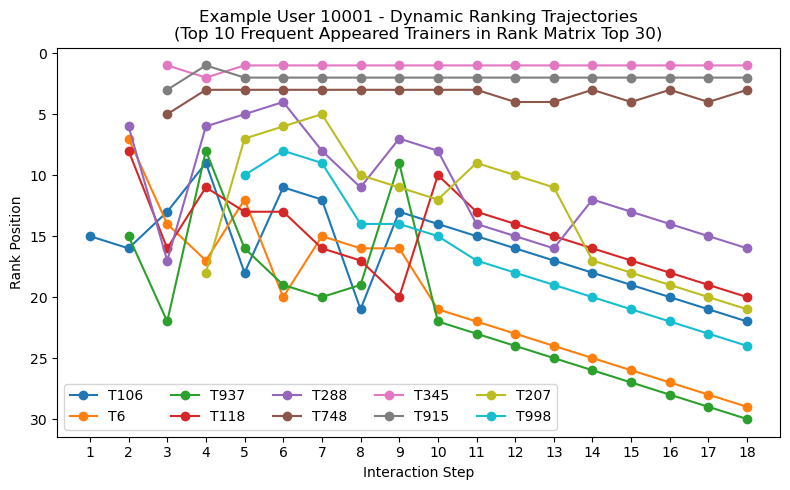

In [11]:
# Visualization of top 10 ranking changes of user 10001
freq = rank_matrix.notna().sum(axis=1)
top10 = freq.sort_values(ascending=False).head(10).index

plt.figure(figsize=(8,5))
for tid in top10:
    ys = rank_matrix.loc[tid, [f"step_{i}" for i in sorted(seq.keys())]]
    plt.plot(sorted(seq.keys()), ys, marker='o', label=f"T{tid}")
plt.gca().invert_yaxis()
plt.xticks(sorted(seq.keys()))
plt.xlabel("Interaction Step")
plt.ylabel("Rank Position")
plt.title(f"Example User {user_id} - Dynamic Ranking Trajectories\n(Top 10 Frequent Appeared Trainers in Rank Matrix Top 30)")
plt.legend(ncol=5, loc='lower left')
plt.tight_layout()
plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/Dynamic Ranking Trajectories(Top 10 Frequent Appeared Trainers in Rank Matrix Top 30).png")  # Save to file
plt.show()

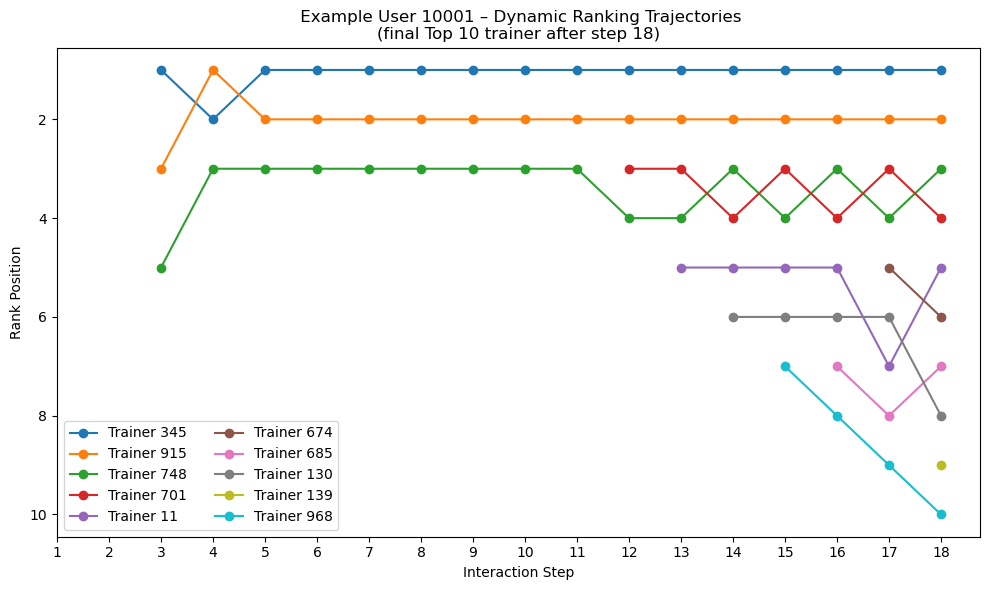


Final Top10 after step 18:
 trainer_id  predicted_score
        345         0.269236
        915         0.269236
        748         0.157284
        701         0.157284
         11        -0.030144
        674        -0.030144
        685        -0.030144
        130        -0.030144
        139        -0.030870
        968        -0.030870


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the Top 10 after all interactions are completed
last_step = max(seq.keys())
final_df  = seq[last_step].reset_index(drop=True)
top10_ids = final_df['trainer_id'].head(10).astype(str).tolist()

# Construct a rank_matrix: the rows are the 10 trainers, the columns are each step, and the values are their ranking positions at that step
steps       = sorted(seq.keys())
rank_matrix = pd.DataFrame(index=top10_ids, columns=steps, dtype=float)

for step in steps:
    df_step = seq[step]
    ids     = df_step['trainer_id'].astype(str).tolist()
    for tid in top10_ids:
        if tid in ids:
            rank_matrix.at[tid, step] = ids.index(tid) + 1
        else:
            rank_matrix.at[tid, step] = np.nan

# Visualisation: A line graph showing the ranking trajectory of the Final Top 10 trainer recommanded 
plt.figure(figsize=(10, 6))
for tid in top10_ids:
    plt.plot(
        steps,
        rank_matrix.loc[tid],
        marker='o',
        label=f'Trainer {tid}'
    )

plt.gca().invert_yaxis()           
plt.xticks(steps)                  
plt.xlabel("Interaction Step")   
plt.ylabel("Rank Position")  
plt.title(f" Example User {user_id} – Dynamic Ranking Trajectories\n(final Top 10 trainer after step {last_step})")
plt.legend(loc="lower left", ncol=2)
plt.tight_layout()
plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/Dynamic Ranking Trajectories(final Top 10 trainer after step 18.png")  # Save to file
plt.show()

print(f"\nFinal Top10 after step {last_step}:")
print(final_df[['trainer_id', 'predicted_score']].head(10).to_string(index=False))


## Evaluation through user interaction level before and after trainer recommendation

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Load and preprocess the trainer dataset
pt_df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv")
for col in ['athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience', 'videos_count']:
    pt_df[col] = pd.to_numeric(pt_df[col], errors='coerce').fillna(0)

# Normalize skewed features with log transform and Min-Max scaling
log_cols = ['total_likes', 'videos_count']
scale_cols = ['workout_recommendations', 'athlete_rating', 'years_experience']
scaler = MinMaxScaler()
for c in log_cols:
    pt_df[f'norm_{c}'] = scaler.fit_transform(np.log1p(pt_df[[c]]))
for c in scale_cols:
    pt_df[f'norm_{c}'] = scaler.fit_transform(pt_df[[c]])

# Compute a static score using PCA on normalized features
feature_cols = [f'norm_{c}' for c in log_cols + scale_cols]
pca = PCA(n_components=1).fit(pt_df[feature_cols])
weights = np.abs(pca.components_[0])
weights /= weights.sum()
pt_df['static_score'] = pt_df[feature_cols].dot(weights)

# Convert specialties string to list
pt_df['speciality_list'] = pt_df['specialities'].str.split(',').apply(lambda lst: [s.strip() for s in lst])

# Load user profiles and parse goals
users = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")
users['goals_list'] = users['user_goals'].str.split(',').apply(lambda lst: [s.strip() for s in lst])

# Create index arrays for all user-trainer pairs
user_ids = users['user_id'].values
trainer_ids = pt_df['trainer_id'].values
U_idx = np.repeat(np.arange(len(user_ids)), len(trainer_ids))
T_idx = np.tile(np.arange(len(trainer_ids)), len(user_ids))

# Vectorized computation of overlap, Jaccard score, and direction match
all_goals = users['goals_list'].tolist()
all_specs = pt_df['speciality_list'].tolist()
overlap = np.empty_like(U_idx, dtype=int)
jaccard = np.empty_like(overlap, dtype=float)
direction = np.empty_like(overlap, dtype=int)
for i, (u, t) in enumerate(zip(U_idx, T_idx)):
    G = set(all_goals[u])
    S = set(all_specs[t])
    I = G & S
    U = G | S
    overlap[i] = len(I)
    jaccard[i] = len(I) / len(U) if U else 0.0
    direction[i] = int(bool(I))

# Assemble features into a DataFrame
feat = pd.DataFrame({
    'user_id': user_ids[U_idx],
    'trainer_id': trainer_ids[T_idx],
    'overlap_count': overlap,
    'jaccard_score': jaccard,
    'direction_match': direction
})
feat = feat.merge(
    pt_df[['trainer_id', 'athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience', 'static_score']],
    on='trainer_id',
    how='left'
)

# Batch predict using the trained LambdaRank model
ranker = lgb.Booster(model_file="/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user.txt")
X = feat[['jaccard_score', 'overlap_count', 'direction_match',
          'athlete_rating', 'total_likes',
          'workout_recommendations', 'years_experience']]
feat['pred_score'] = ranker.predict(X)

# Select top-18 trainers per user based on predicted score
topN = feat.groupby('user_id', group_keys=False).apply(lambda df: df.nlargest(18, 'pred_score'))

# Helper to construct final label from simulated behavior
def construct_label(watched_count, rated, score_given):
    if rated == 1:
        return 5 if score_given > 3 else 4
    if watched_count >= 3:
        return 3
    if watched_count > 1:
        return 2
    if watched_count == 1:
        return 1
    return 0

# Simulate user interactions on the reduced recommendation set
VIDEO_NUM = 5
ALPHA = 0.05
P_MAX = 0.95
records = []

for _, row in topN.iterrows():
    base_prob = min(0.2 + 0.2 * row['overlap_count'], P_MAX)
    watch_sum = 0
    watches = []
    for _ in range(VIDEO_NUM):
        p = min(base_prob + ALPHA * watch_sum, P_MAX)
        w = int(random.random() < p)
        watches.append(w)
        watch_sum += w
    if watch_sum >= 2:
        rated_prob = min(0.1 + 0.15 * watch_sum + 0.4 * row['jaccard_score'], P_MAX)
        rated = int(random.random() < rated_prob)
    else:
        rated = 0
    if rated:
        raw = np.random.normal(loc=2.5 + 0.3 * watch_sum + 1.5 * row['jaccard_score'], scale=1.2)
        score_given = int(np.clip(round(raw), 1, 5))
    else:
        score_given = 0
    label = construct_label(watch_sum, rated, score_given)
    records.append({
        'user_id': row['user_id'],
        'trainer_id': row['trainer_id'],
        **{f'watch_v{i+1}': w for i, w in enumerate(watches)},
        'watched_count': watch_sum,
        'rated': rated,
        'score_given': score_given,
        'overlap_count': row['overlap_count'],
        'jaccard_score': row['jaccard_score'],
        'direction_match': row['direction_match'],
        'label': label
    })

# Save the new synthetic interaction data and compare distributions
new_df = pd.DataFrame(records)
new_df.to_csv("/Users/cailingchen/Desktop/Final Project/synthetic_second_round_user_behavior.csv", index=False)

orig = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")
print("Original distribution:")
print(orig['label'].value_counts().sort_index())
print("\nNew distribution:")
print(new_df['label'].value_counts().sort_index())


/var/folders/f6/67p1_n6x3f78l8q_dvdz6r8h0000gn/T/ipykernel_12171/3573618921.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  topN = feat.groupby('user_id', group_keys=False).apply(lambda df: df.nlargest(18, 'pred_score'))


Original distribution:
label
0    27306
1    31402
2    11410
3     3991
4     8055
5     7836
Name: count, dtype: int64

New distribution:
label
0    12038
1    20872
2     8649
3     4800
4    10003
5    33638
Name: count, dtype: int64


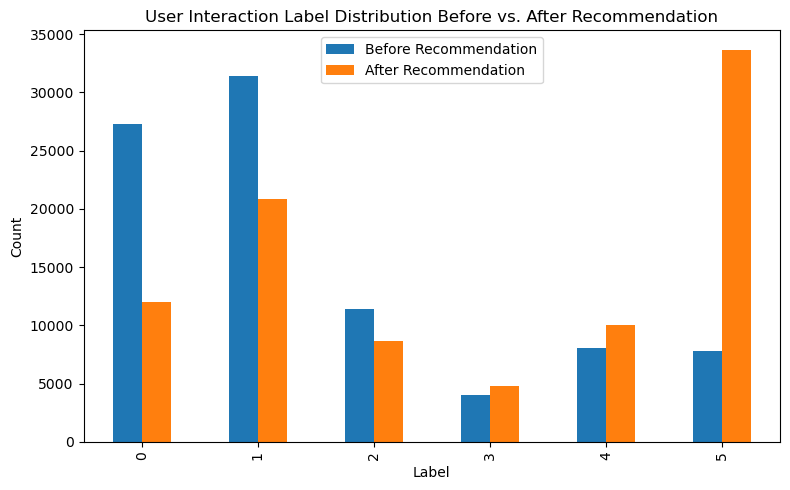

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load original and re-simulated datasets
orig = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")
new  = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_second_round_user_behavior.csv")

# Compute counts of each label
orig_counts = orig['label'].value_counts().sort_index()
new_counts  = new['label'].value_counts().sort_index()

# Combine into one DataFrame
df_compare = pd.DataFrame({
    'Before Recommendation': orig_counts,
    'After Recommendation': new_counts
}).fillna(0)

# Plot side-by-side bar chart
ax = df_compare.plot(kind='bar', figsize=(8,5))
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('User Interaction Label Distribution Before vs. After Recommendation')
plt.tight_layout()

plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/Label_distribution_comparison.png")  # Save to file
plt.show()


## Add collaborative filtering to previous model

### Collaborative filtering by user‑based nearest‐neighbors

In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Load interaction data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")

# Split users into train/validation/test (70/15/15)
np.random.seed(42)
uids = df['user_id'].unique()
np.random.shuffle(uids)
n = len(uids)
train_u = set(uids[:int(0.7 * n)])
val_u   = set(uids[int(0.7 * n):int(0.85 * n)])
test_u  = set(uids[int(0.85 * n):])

train_df = df[df['user_id'].isin(train_u)].reset_index(drop=True)
val_df   = df[df['user_id'].isin(val_u)].reset_index(drop=True)
test_df  = df[df['user_id'].isin(test_u)].reset_index(drop=True)

# Define features, label, and group key
features  = [
    'jaccard_score', 'overlap_count', 'direction_match',
    'athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience'
]
label_col = 'label'
group_col = 'user_id'

def prepare_group(dataframe, col):
    return dataframe.groupby(col).size().tolist()

# Prepare LightGBM datasets
dtrain = lgb.Dataset(
    train_df[features],
    label=train_df[label_col],
    group=prepare_group(train_df, group_col)
)
dval = lgb.Dataset(
    val_df[features],
    label=val_df[label_col],
    group=prepare_group(val_df, group_col),
    reference=dtrain
)

# LambdaRank hyperparameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [5, 10, 15],
    'lambdarank_truncation_level': 15,
    'learning_rate': 0.05,
    'num_leaves': 6,
    'min_data_in_leaf': 20,
    'verbose': -1,
}

# Train LambdaRank model with early stopping
ranker = lgb.train(
    params,
    dtrain,
    valid_sets=[dval],
    valid_names=['validation'],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=10)
    ]
)

# Apply model to test set and evaluate
test_df = test_df.copy()
test_df['predicted_score'] = ranker.predict(test_df[features])

ndcg_res = {k: [] for k in (5, 10, 15)}
map_res  = []
for _, grp in test_df.groupby(group_col):
    y_true = grp[label_col].values.reshape(1, -1)
    y_pred = grp['predicted_score'].values.reshape(1, -1)
    for k in ndcg_res:
        ndcg_res[k].append(ndcg_score(y_true, y_pred, k=k))
    y_bin = (grp[label_col].values > 0).astype(int)
    if np.any(y_bin):
        map_res.append(average_precision_score(y_bin, grp['predicted_score'].values))

print("LambdaRank Results:")
for k, vals in ndcg_res.items():
    print(f"  NDCG@{k}: {np.mean(vals):.4f}")
print(f"  MAP: {np.mean(map_res):.4f}" if map_res else "  MAP: undefined")


# ---------------------------------------------------------------------
# Collaborative Filtering: leave-5-out evaluation per user
# ---------------------------------------------------------------------

# Build full user–trainer interaction pivot
full_pivot = df.pivot_table(
    index='user_id',
    columns='trainer_id',
    values=label_col,
    fill_value=0
)
users_all = full_pivot.index.tolist()
items_all = full_pivot.columns.tolist()

cf_ndcg = {5: [], 10: [], 15: []}
cf_map  = []

for user in users_all:
    user_hist = df[df['user_id'] == user]
    if len(user_hist) < 6:
        continue

    # Randomly leave out 5 interactions for testing
    test_rows  = user_hist.sample(5, random_state=42)
    train_rows = user_hist.drop(test_rows.index)

    # Rebuild this user's row in the pivot matrix
    mat = full_pivot.copy()
    mat.loc[user] = 0
    for tid, lab in zip(train_rows['trainer_id'], train_rows[label_col]):
        mat.at[user, tid] = lab

    # Fit user–user CF on modified matrix
    X = csr_matrix(mat.values)
    nn = NearestNeighbors(n_neighbors=10, metric='cosine')
    nn.fit(X)

    uidx = users_all.index(user)
    _, nbrs = nn.kneighbors(X[uidx], return_distance=True)
    neighbors = [users_all[i] for i in nbrs.flatten() if users_all[i] != user]

    # Aggregate neighbor labels to score trainers
    nbr_df = df[df['user_id'].isin(neighbors)]
    cf_scores = nbr_df.groupby('trainer_id')[label_col].mean()

    # Build full ranking for evaluation
    y_true = []
    y_pred = []
    for tid in items_all:
        if tid in test_rows['trainer_id'].values:
            lab = test_rows.loc[test_rows['trainer_id'] == tid, label_col].iloc[0]
            y_true.append(int(lab > 0))
        else:
            y_true.append(0)
        y_pred.append(cf_scores.get(tid, 0))
    y_true = np.array(y_true).reshape(1, -1)
    y_pred = np.array(y_pred).reshape(1, -1)

    # Compute NDCG@k and MAP
    for k in cf_ndcg:
        cf_ndcg[k].append(ndcg_score(y_true, y_pred, k=k))
    cf_map.append(average_precision_score(y_true.flatten(), y_pred.flatten()))

print("\nCollaborative Filtering (leave-5-out) Results:")
for k, vals in cf_ndcg.items():
    print(f"  NDCG@{k}: {np.mean(vals):.4f}")
print(f"  MAP: {np.mean(cf_map):.4f}" if cf_map else "  MAP: undefined")

# Save collaborative-enhanced LambdaRank model as well
ranker.save_model("/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_collaborative.txt")


Training until validation scores don't improve for 50 rounds
[10]	validation's ndcg@5: 0.444911	validation's ndcg@10: 0.53218	validation's ndcg@15: 0.621101
[20]	validation's ndcg@5: 0.444313	validation's ndcg@10: 0.530638	validation's ndcg@15: 0.620028
[30]	validation's ndcg@5: 0.444725	validation's ndcg@10: 0.533289	validation's ndcg@15: 0.621211
[40]	validation's ndcg@5: 0.443553	validation's ndcg@10: 0.530817	validation's ndcg@15: 0.61854
[50]	validation's ndcg@5: 0.444814	validation's ndcg@10: 0.53182	validation's ndcg@15: 0.620854
Early stopping, best iteration is:
[4]	validation's ndcg@5: 0.457336	validation's ndcg@10: 0.545225	validation's ndcg@15: 0.630808
LambdaRank Results:
  NDCG@5: 0.5326
  NDCG@10: 0.6036
  NDCG@15: 0.6992
  MAP: 0.7510


/Users/cailingchen/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/cailingchen/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/cailingchen/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/cailingchen/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/cailingchen/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, rec


Collaborative Filtering (leave-5-out) Results:
  NDCG@5: 0.0041
  NDCG@10: 0.0068
  NDCG@15: 0.0095
  MAP: 0.0072


In [8]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# load interaction data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")

# split users into train/validation/test (70/15/15)
np.random.seed(42)
uids = df['user_id'].unique()
np.random.shuffle(uids)
n = len(uids)
train_u = set(uids[:int(0.7 * n)])
val_u   = set(uids[int(0.7 * n):int(0.85 * n)])
test_u  = set(uids[int(0.85 * n):])

train_df = df[df['user_id'].isin(train_u)].reset_index(drop=True)
val_df   = df[df['user_id'].isin(val_u)].reset_index(drop=True)
test_df  = df[df['user_id'].isin(test_u)].reset_index(drop=True)

# define features, label and group key
features  = [
    'jaccard_score', 'overlap_count', 'direction_match',
    'athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience'
]
label_col = 'label'
group_col = 'user_id'

def prepare_group(data, col):
    return data.groupby(col).size().tolist()

# prepare LightGBM datasets
dtrain = lgb.Dataset(
    train_df[features],
    label=train_df[label_col],
    group=prepare_group(train_df, group_col)
)
dval = lgb.Dataset(
    val_df[features],
    label=val_df[label_col],
    group=prepare_group(val_df, group_col),
    reference=dtrain
)

# set LambdaRank hyperparameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [5, 10, 15],
    'lambdarank_truncation_level': 15,
    'learning_rate': 0.05,
    'num_leaves': 6,
    'min_data_in_leaf': 20,
    'verbose': -1
}

# train LambdaRank model
ranker = lgb.train(
    params,
    dtrain,
    valid_sets=[dval],
    valid_names=['validation'],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=10)
    ]
)

# predict and evaluate LambdaRank on test set
test_df = test_df.copy()
test_df['predicted_score'] = ranker.predict(test_df[features])

ndcg_res = {5: [], 10: [], 15: []}
map_res  = []

for _, grp in test_df.groupby(group_col):
    if grp[label_col].sum() == 0:
        continue
    y_true = grp[label_col].values.reshape(1, -1)
    y_pred = grp['predicted_score'].values.reshape(1, -1)
    for k in ndcg_res:
        ndcg_res[k].append(ndcg_score(y_true, y_pred, k=k))
    y_bin = (grp[label_col].values > 0).astype(int)
    map_res.append(average_precision_score(y_bin, grp['predicted_score'].values))

print("LambdaRank Results:")
for k, vals in ndcg_res.items():
    print(f"  NDCG@{k}: {np.mean(vals):.4f}")
print(f"  MAP: {np.mean(map_res):.4f}")


# build full user–trainer pivot for CF
full_pivot = df.pivot_table(
    index='user_id',
    columns='trainer_id',
    values=label_col,
    fill_value=0
)
users_all = full_pivot.index.tolist()

cf_ndcg = {5: [], 10: [], 15: []}
cf_map  = []

recall_k = 100
for user in users_all:
    user_hist = df[df['user_id'] == user]
    if len(user_hist) < 6:
        continue
    # leave out 5 interactions for testing
    test_rows = user_hist.sample(5, random_state=42)
    train_rows = user_hist.drop(test_rows.index)
    # rebuild user row in pivot
    mat = full_pivot.copy()
    mat.loc[user] = 0
    for tid, lab in zip(train_rows['trainer_id'], train_rows[label_col]):
        mat.at[user, tid] = lab
    # fit CF on modified matrix
    X = csr_matrix(mat.values)
    nn = NearestNeighbors(n_neighbors=10, metric='cosine')
    nn.fit(X)
    uidx = users_all.index(user)
    _, nbrs = nn.kneighbors(X[uidx], return_distance=True)
    neighbors = [users_all[i] for i in nbrs.flatten() if users_all[i] != user]
    # aggregate neighbor labels
    nbr_df = df[df['user_id'].isin(neighbors)]
    cf_scores = nbr_df.groupby('trainer_id')[label_col].mean().to_dict()
    # recall top-k by CF score
    recall_ids = sorted(cf_scores, key=cf_scores.get, reverse=True)[:recall_k]
    # build y_true, y_pred for recall pool
    y_true = []
    y_pred = []
    for tid in recall_ids:
        lab = 0
        if tid in test_rows['trainer_id'].values:
            lab = int(test_rows.loc[test_rows['trainer_id'] == tid, label_col].iloc[0] > 0)
        y_true.append(lab)
        y_pred.append(cf_scores.get(tid, 0))
    if sum(y_true) == 0:
        continue
    y_true_arr = np.array(y_true).reshape(1, -1)
    y_pred_arr = np.array(y_pred).reshape(1, -1)
    for k in cf_ndcg:
        cf_ndcg[k].append(ndcg_score(y_true_arr, y_pred_arr, k=k))
    cf_map.append(average_precision_score(y_true, y_pred))

print("\nCollaborative Filtering Results (leave-5-out + recall):")
for k, vals in cf_ndcg.items():
    print(f"  NDCG@{k}: {np.mean(vals):.4f}")
print(f"  MAP: {np.mean(cf_map):.4f}")

# save collaborative-enhanced model
ranker.save_model("/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_collaborative.txt")


Training until validation scores don't improve for 50 rounds
[10]	validation's ndcg@5: 0.444911	validation's ndcg@10: 0.53218	validation's ndcg@15: 0.621101
[20]	validation's ndcg@5: 0.444313	validation's ndcg@10: 0.530638	validation's ndcg@15: 0.620028
[30]	validation's ndcg@5: 0.444725	validation's ndcg@10: 0.533289	validation's ndcg@15: 0.621211
[40]	validation's ndcg@5: 0.443553	validation's ndcg@10: 0.530817	validation's ndcg@15: 0.61854
[50]	validation's ndcg@5: 0.444814	validation's ndcg@10: 0.53182	validation's ndcg@15: 0.620854
Early stopping, best iteration is:
[4]	validation's ndcg@5: 0.457336	validation's ndcg@10: 0.545225	validation's ndcg@15: 0.630808
LambdaRank Results:
  NDCG@5: 0.5326
  NDCG@10: 0.6036
  NDCG@15: 0.6992
  MAP: 0.7510

Collaborative Filtering Results (leave-5-out + recall):
  NDCG@5: 0.0218
  NDCG@10: 0.0356
  NDCG@15: 0.0495
  MAP: 0.0301


In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.metrics import ndcg_score, average_precision_score

df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")

np.random.seed(42)
uids = df['user_id'].unique()
np.random.shuffle(uids)
n = len(uids)
train_u = set(uids[:int(0.7 * n)])
val_u   = set(uids[int(0.7 * n):int(0.85 * n)])
test_u  = set(uids[int(0.85 * n):])

train_df = df[df['user_id'].isin(train_u)].reset_index(drop=True)
val_df   = df[df['user_id'].isin(val_u)].reset_index(drop=True)
test_df  = df[df['user_id'].isin(test_u)].reset_index(drop=True)

features  = [
    'jaccard_score','overlap_count','direction_match',
    'athlete_rating','total_likes','workout_recommendations','years_experience'
]
label_col = 'label'
group_col = 'user_id'

def prepare_group(data, col):
    return data.groupby(col).size().tolist()

dtrain = lgb.Dataset(
    train_df[features], label=train_df[label_col],
    group=prepare_group(train_df, group_col)
)
dval = lgb.Dataset(
    val_df[features], label=val_df[label_col],
    group=prepare_group(val_df, group_col),
    reference=dtrain
)

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [5, 10, 15],
    'lambdarank_truncation_level': 15,
    'learning_rate': 0.05,
    'num_leaves': 6,
    'min_data_in_leaf': 20,
    'verbose': -1
}

ranker = lgb.train(
    params,
    dtrain,
    valid_sets=[dval],
    valid_names=['validation'],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=10)
    ]
)

test_df = test_df.copy()
test_df['predicted_score'] = ranker.predict(test_df[features])

ndcg_res = {5:[], 10:[], 15:[]}
map_res  = []

for _, g in test_df.groupby(group_col):
    if g[label_col].sum()==0:
        continue
    y_true = g[label_col].values.reshape(1, -1)
    y_pred = g['predicted_score'].values.reshape(1, -1)
    for k in ndcg_res:
        ndcg_res[k].append(ndcg_score(y_true, y_pred, k=k))
    yb = (g[label_col].values>0).astype(int)
    map_res.append(average_precision_score(yb, g['predicted_score'].values))

print("LambdaRank Results:")
for k,v in ndcg_res.items():
    print(f"  NDCG@{k}: {np.mean(v):.4f}")
print(f"  MAP: {np.mean(map_res):.4f}")


full_pivot = df.pivot_table(
    index='user_id', columns='trainer_id',
    values=label_col, fill_value=0
)
users_all = full_pivot.index.tolist()
items_all = full_pivot.columns.tolist()

nn_matrix = csr_matrix(full_pivot.values)
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(nn_matrix)

recall_k = 100
cf_ndcg  = {5:[], 10:[], 15:[]}
cf_map   = []

for user in users_all:
    hist = df[df['user_id']==user]
    if len(hist)<6:
        continue
    test_rows  = hist.sample(5, random_state=42)
    train_rows = hist.drop(test_rows.index)
    mat = full_pivot.copy()
    mat.loc[user] = 0
    for tid, lab in zip(train_rows['trainer_id'], train_rows[label_col]):
        mat.at[user, tid] = lab
    X = csr_matrix(mat.values)
    nn.fit(X)
    uidx, = np.where(np.array(users_all)==user)
    dists, nbrs = nn.kneighbors(X[uidx], return_distance=True)
    neighbors = [users_all[i] for i in nbrs.flatten() if users_all[i]!=user]
    nbr_df = df[df['user_id'].isin(neighbors)]
    cf_scores = nbr_df.groupby('trainer_id')[label_col].mean().to_dict()
    recall_ids = sorted(cf_scores, key=cf_scores.get, reverse=True)[:recall_k]
    y_true = []
    y_pred = []
    for tid in recall_ids:
        y_true.append(int(tid in test_rows['trainer_id'].values and
                          test_rows.loc[test_rows['trainer_id']==tid, label_col].iloc[0]>0))
        y_pred.append(cf_scores.get(tid, 0))
    if sum(y_true)==0:
        continue
    y_true_arr = np.array(y_true).reshape(1,-1)
    y_pred_arr = np.array(y_pred).reshape(1,-1)
    for k in cf_ndcg:
        cf_ndcg[k].append(ndcg_score(y_true_arr, y_pred_arr, k=k))
    cf_map.append(average_precision_score(y_true, y_pred))

print("\nHybrid CF+LambdaRank Results:")
for k, vals in cf_ndcg.items():
    print(f"  NDCG@{k}: {np.mean(vals):.4f}")
print(f"  MAP: {np.mean(cf_map):.4f}")

ranker.save_model("/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_hybrid.txt")


Training until validation scores don't improve for 50 rounds
[10]	validation's ndcg@5: 0.444911	validation's ndcg@10: 0.53218	validation's ndcg@15: 0.621101
[20]	validation's ndcg@5: 0.444313	validation's ndcg@10: 0.530638	validation's ndcg@15: 0.620028
[30]	validation's ndcg@5: 0.444725	validation's ndcg@10: 0.533289	validation's ndcg@15: 0.621211
[40]	validation's ndcg@5: 0.443553	validation's ndcg@10: 0.530817	validation's ndcg@15: 0.61854
[50]	validation's ndcg@5: 0.444814	validation's ndcg@10: 0.53182	validation's ndcg@15: 0.620854
Early stopping, best iteration is:
[4]	validation's ndcg@5: 0.457336	validation's ndcg@10: 0.545225	validation's ndcg@15: 0.630808
LambdaRank Results:
  NDCG@5: 0.5326
  NDCG@10: 0.6036
  NDCG@15: 0.6992
  MAP: 0.7510

Hybrid CF+LambdaRank Results:
  NDCG@5: 0.0218
  NDCG@10: 0.0356
  NDCG@15: 0.0495
  MAP: 0.0301


In [2]:
# Module: ALS Training and Saving Factors

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import os

# load interaction data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")

# split users into train/validation/test (we only need train for ALS)
np.random.seed(42)
uids = df['user_id'].unique()
np.random.shuffle(uids)
n = len(uids)
train_u = set(uids[:int(0.7 * n)])
train_df = df[df['user_id'].isin(train_u)].reset_index(drop=True)

# build sparse interaction matrix R (users × trainers)
user_list = train_df['user_id'].unique().tolist()
item_list = train_df['trainer_id'].unique().tolist()
uid_map   = {u:i for i,u in enumerate(user_list)}
tid_map   = {t:i for i,t in enumerate(item_list)}

rows = train_df['user_id'].map(uid_map)
cols = train_df['trainer_id'].map(tid_map)
data = train_df['label'].astype(float)

R = csr_matrix((data, (rows, cols)),
               shape=(len(user_list), len(item_list)))

# manual implicit ALS implementation
def implicit_als(R, factors=20, reg=0.1, iterations=15, alpha=40.0):
    m, n = R.shape
    U = np.random.normal(scale=0.01, size=(m, factors))
    V = np.random.normal(scale=0.01, size=(n, factors))
    I = np.eye(factors)

    C = R.copy().astype(float)
    C.data = 1 + alpha * C.data
    C = C.tocsr()

    for _ in range(iterations):
        VtV = V.T @ V
        for u in range(m):
            Cu = C[u,:].toarray().ravel()
            CuI = np.diag(Cu)
            A = VtV + V.T @ (CuI - np.eye(n)) @ V + reg * I
            b = V.T @ (Cu * R[u,:].toarray().ravel())
            U[u] = np.linalg.solve(A, b)
        UtU = U.T @ U
        for i in range(n):
            Ci = C[:,i].toarray().ravel()
            CiI = np.diag(Ci)
            A = UtU + U.T @ (CiI - np.eye(m)) @ U + reg * I
            b = U.T @ (Ci * R[:,i].toarray().ravel())
            V[i] = np.linalg.solve(A, b)
    return U, V

# train factors
U, V = implicit_als(R, factors=50, reg=0.1, iterations=10)

# save factors as text
save_dir = "/Users/cailingchen/Desktop/Final Project/Model"
os.makedirs(save_dir, exist_ok=True)
np.savetxt(f"{save_dir}/als_user_factors.txt", U, fmt="%.6f")
np.savetxt(f"{save_dir}/als_item_factors.txt", V, fmt="%.6f")


In [7]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics import ndcg_score, average_precision_score

# load interactions and ALS factors
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/synthetic_training_data_user.csv")
U  = np.loadtxt("/Users/cailingchen/Desktop/Final Project/Model/als_user_factors.txt")
V  = np.loadtxt("/Users/cailingchen/Desktop/Final Project/Model/als_item_factors.txt")

# reconstruct exactly the same train‐split mapping used during ALS training
np.random.seed(42)
all_uids = df['user_id'].unique()
np.random.shuffle(all_uids)
n = len(all_uids)
train_u = set(all_uids[:int(0.7 * n)])

# build maps over only train users/items
train_df  = df[df['user_id'].isin(train_u)]
user_list = train_df['user_id'].unique().tolist()
item_list = train_df['trainer_id'].unique().tolist()
uid_map   = {u:i for i,u in enumerate(user_list)}
tid_map   = {t:i for i,t in enumerate(item_list)}

# evaluation: leave‐5‐out + recall, only on train users
leave_k   = 5
recall_k  = 100
ndcg_res  = {5: [], 10: [], 15: []}
map_res   = []

for user in user_list:
    hist = df[df['user_id'] == user]
    if len(hist) < leave_k + 1:
        continue

    # leave‐5‐out on this user's full history
    test_rows  = hist.sample(leave_k, random_state=42)
    train_rows = hist.drop(test_rows.index)
    seen       = set(train_rows['trainer_id'])

    # compute scores = U[u]·V^T
    uidx   = uid_map[user]
    scores = V @ U[uidx]

    # form recall pool of top‐100 unseen
    candidates = [(t, scores[tid_map[t]])
                  for t in item_list if t not in seen]
    candidates.sort(key=lambda x: x[1], reverse=True)
    recall_ids, recall_scores = zip(*candidates[:recall_k])

    # build y_true / y_pred vectors
    y_true = [
        int((test_rows['trainer_id'] == t).any() and
            int(test_rows.loc[test_rows['trainer_id'] == t, 'label'].iloc[0]) > 0)
        for t in recall_ids
    ]
    if sum(y_true) == 0:
        continue

    y_pred      = list(recall_scores)
    y_true_arr  = np.array(y_true).reshape(1, -1)
    y_pred_arr  = np.array(y_pred).reshape(1, -1)

    for k in ndcg_res:
        ndcg_res[k].append(ndcg_score(y_true_arr, y_pred_arr, k=k))
    map_res.append(average_precision_score(y_true, y_pred))

print("ALS Evaluation on trained users (leave-5-out + recall):")
for k, vals in ndcg_res.items():
    if vals:
        print(f"  NDCG@{k}: {np.mean(vals):.4f}")
    else:
        print(f"  NDCG@{k}: None (no valid users)")
if map_res:
    print(f"  MAP: {np.mean(map_res):.4f}")
else:
    print("  MAP: None (no valid users)")


ALS Evaluation on trained users (leave-5-out + recall):
  NDCG@5: 0.0076
  NDCG@10: 0.0263
  NDCG@15: 0.0548
  MAP: 0.0533
